## Setup

In [9]:
# RUN SETUP.SH BEFORE RUNNING THIS IPYNB
# REQUIREMENTS FOR SETUP.SH:
# python 3.11.8
# pip 23.3.1

import pandas as pd
import pickle
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression Classifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN, RandomOverSampler
from scipy.sparse import hstack, csr_matrix, save_npz, load_npz
import spacy
import re
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif
import nltk
from readability import Readability
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from collections import Counter
import csv


In [10]:
SEED = 42 # seed random state for comparison, testing
PARTITION_SIZE = 500 # Adjust lower if potato PC and higher if gaming rig or want results closer to actual
enable_all_data = True # SET TO FALSE IF PREPROCESSING TAKES A LONG TIME (True = test on PARTITION_SIZE training and PARTITION_SIZE testing samples)
enable_features_from_savefile = False
enable_validation_data = False
enable_model_from_savefile = False
use_external_dataset = True

# Improvements to model
enable_NER_masking = True
use_ner_from_savefile = False
enable_rejection_classification = False

## Pre-processing

In [11]:
df = pd.read_csv('../raw_data/fulltrain.csv', header=None, index_col = False)
# df.head()

In [12]:
df = df if enable_all_data else df.sample(n=PARTITION_SIZE, random_state=SEED)

X_train = df.iloc[:, 1] 
y_train = df.iloc[:, 0]

# print(X_train)
# print(y_train)

# print(len(X_train))
# print(len(y_train))

# y_train.value_counts()

In [13]:
spacy_model = spacy.load("en_core_web_lg")

def NER_masking_preprocessing(sentences):
    result = []
    sentences = spacy_model.pipe(sentences.tolist(), batch_size=128, n_process=6)
    for document in sentences:
        sentence = document.text
        for word in document.ents:
            sentence = re.sub(re.escape(word.text), f"<{word.label_}>", sentence)
        result.append(sentence)
    return pd.Series(result)

if enable_NER_masking and not use_ner_from_savefile:
    X_train = NER_masking_preprocessing(X_train)

In [14]:
ner_masked_filename = "NER_masked_train.csv"
if enable_NER_masking and not use_ner_from_savefile:
    # Save to file
    X_train.to_csv(ner_masked_filename, index=False, header=False)
elif enable_NER_masking:
    X_train = pd.read_csv(ner_masked_filename, header=None, index_col=False)

### Train-Validation Split

In [15]:
if enable_validation_data:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

### Feature analysis

In [16]:
def count_analysis_bar(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].bar(unique_vals, counts)
        axs[i-1].set_xlabel(f'{feature_name}')
        axs[i-1].set_ylabel(f'Frequency of {feature_name}')
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

def count_analysis_scatter(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].scatter(unique_vals, counts)
        axs[i-1].set_xlabel(f'{feature_name}')
        axs[i-1].set_ylabel(f'Frequency of {feature_name}')
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

def count_analysis_boxplot(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals = np.unique(counts_i)
        axs[i-1].boxplot(unique_vals)
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

### Feature Engineering

In [17]:
# Feature set:
# 1) TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [18]:
# Consolidation of feature sets into single vector:
X_train_filename = "tfidf"
if enable_features_from_savefile:
    # Load features as sparse matrix (Download file from Google Drive)
    X_train = load_npz(f"{X_train_filename}.npz")
else:
    X_train = hstack([X_train_tfidf])
    save_npz(f"{X_train_filename}.npz", X_train)

### Scaler

In [19]:
# scaler = MaxAbsScaler() # Sparse matrix
# X_train = scaler.fit_transform(X_train)

### Feature selection: SelectPercentile

In [20]:
# Take top 10% of features by scores
# feature_selector = SelectPercentile(f_classif)
# X_train = feature_selector.fit_transform(X_train, y_train)

### Oversampling

In [21]:
# RandomOverSampler
ros = RandomOverSampler(random_state=SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

## Models

### Logistic Regression Model [LogisticRegression]

In [22]:
model_path = 'LogisticRegression-tfidf-randomoversampler.pkl'
if not enable_model_from_savefile:
    model = LogisticRegression(solver = 'saga', max_iter=3000, random_state=SEED).fit(X_train, y_train)
    # Save model
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
else:
    # Load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

## Validation

In [23]:
# Apply feature engineering on X_val
if enable_validation_data:
    X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [24]:
# Consolidation of feature sets:
if enable_validation_data:
    X_val_final = hstack([X_val_tfidf])
    # X_val_final = scaler.transform(X_val_final)
    # X_val_final = feature_selector.transform(X_val_final)

In [25]:
# # obtain predictions on validation data
if enable_validation_data:
    y_val_predicted = model.predict(X_val_final)

    # evaluate model training metrics with macro f1 score
    f1_score(y_val, y_val_predicted, average='macro')

## Test Data

In [26]:
# TEST DATA 
if use_external_dataset:
    test_df = pd.read_csv('../external-dataset/opensources_fakenewscorpus_balancedtest.csv', index_col = False)
else:
    test_df = pd.read_csv('../raw_data/balancedtest.csv', index_col = False)
    test_df = test_df if enable_all_data else test_df.sample(PARTITION_SIZE, random_state=SEED)

# print(test_df)
print(test_df.head())

   1  \
0  1   
1  1   
2  1   
3  1   
4  1   

  The phoney war was over today with Prime Minister Brown and sidekick George W Blair taking centre stage, Prince Charles' funeral and the marriage of famed pigeon fancier Pope John Paul II to his long time love Camilla Parker Bowles, becoming a distant memory.\n\nIn a scene reminiscent of the couples' electioneering kickstart in 2001 when they stunned a school hall audience with their professions of the love that dare not speak its' name, Brown and G.W.B skipped hand in hand to an abandoned puppy sanctuary in deepest Birmingham.\n\nHotly followed by a poop scoop hungry press pack, the late middle aged lovers were seen to fondle several cute pooches before plumping for their favourite, a mongrel, quaintly named Rover.\n\nRover, while no spring chicken himself, has had a chequered past having been briefly adopted by Germans some years ago.It is believed that his German owners had only wanted to milk him for all he was worth, dog cheese be

In [27]:
X_test = test_df.iloc[:, 1]
y_test = test_df.iloc[:, 0]

# print(X_test.head())
# print(y_test.head())

In [28]:
test_ner_masked_filename = "NER_masked_external_test.csv"
if enable_NER_masking and not use_ner_from_savefile:
    X_test = NER_masking_preprocessing(X_test)
    # Save to file
    X_test.to_csv(test_ner_masked_filename, index=False, header=False)
elif enable_NER_masking:
    X_test = pd.read_csv(test_ner_masked_filename, header=None, index_col=False)


### Feature Engineering (Test Data)

In [29]:
# Apply feature engineering on X_test
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [30]:
# Consolidation of feature transformations into single vector
X_test_final = hstack([X_test_tfidf])
# X_test_final = scaler.transform(X_test_final)
# X_test_final = feature_selector.transform(X_test_final)

### Metrics

#### Accuracy, precision, recall, F1

In [31]:
# obtain predictions on test data
y_pred = model.predict(X_test_final)

# evaluate model training metrics with macro f1 score
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_pred)

In [32]:
print(f'Test Accuracy: {test_accuracy:.8f},\tTest Precision: {test_precision:.8f},\tTest Recall: {test_recall:.8f},\tTest F1: {test_f1:.8f}')

class_test_precision, class_test_recall, class_test_f1, class_ = precision_recall_fscore_support(y_test, y_pred)
for i in range(4):
    print(f'Class {i}:\tTest Precision: {class_test_precision[i]:.8f},\tTest Recall: {class_test_recall[i]:.8f},\tTest f1: {class_test_f1[i]:.8f}')

pd.Series(y_pred).value_counts()

Test Accuracy: 0.41404023,	Test Precision: 0.38680580,	Test Recall: 0.41404155,	Test F1: 0.37259913
Class 0:	Test Precision: 0.60335970,	Test Recall: 0.49329955,	Test f1: 0.54280684
Class 1:	Test Precision: 0.22857869,	Test Recall: 0.05993333,	Test f1: 0.09496646
Class 2:	Test Precision: 0.28564197,	Test Recall: 0.30093333,	Test f1: 0.29308834
Class 3:	Test Precision: 0.42964286,	Test Recall: 0.80200000,	Test f1: 0.55953488


4    28000
3    15803
1    12263
2     3933
Name: count, dtype: int64

## Tackling Generalizability

#### Feature selection percentage - coefficients for each feature

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

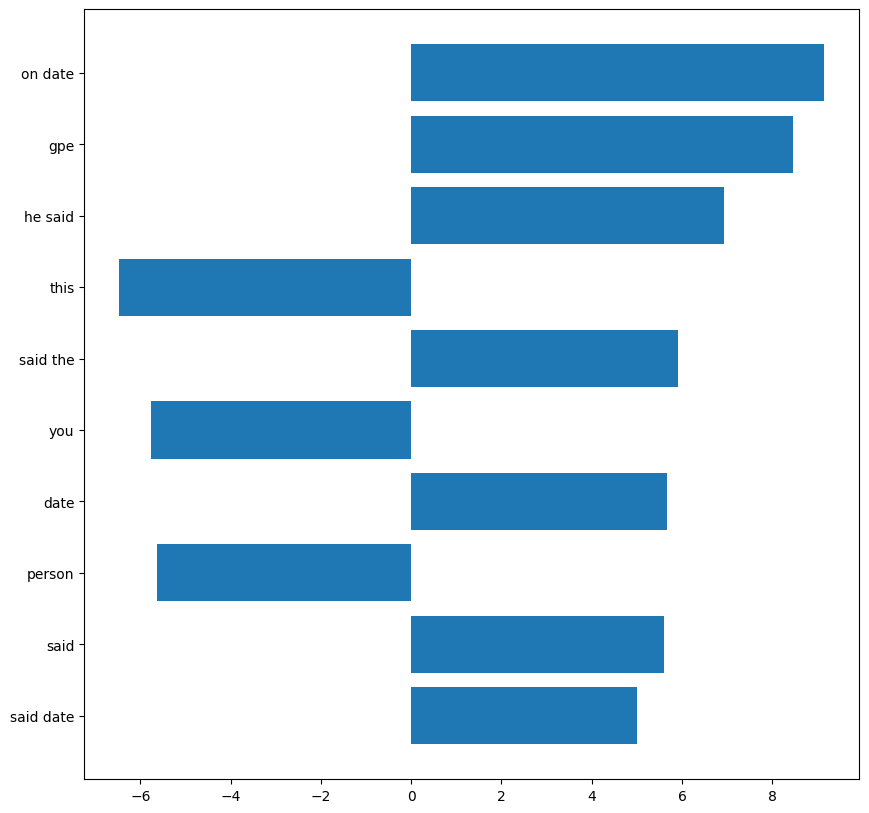

In [33]:
# Get all column names for features
feature_names = np.empty(0)
feature_names = np.concatenate((feature_names, tfidf_vectorizer.get_feature_names_out()))

# Get coefficients for Logistic Regression
labels_coefficients = model.coef_
NUM_HIGHEST_ABS_COEFF = 10
row = 1
for label_coefficients in labels_coefficients:
    plt.clf()
    plt.figure(figsize=(10, 10))
    label_coefficients_abs = np.abs(label_coefficients)
    top_indices = np.argsort(label_coefficients_abs)[-NUM_HIGHEST_ABS_COEFF:]
    top_feature_names = feature_names[top_indices]
    top_coeffs = label_coefficients[top_indices]
    plt.barh(top_feature_names, top_coeffs)
    plt.savefig(f"Best-features-coeff-label-{row}.png")
    row += 1


#### Rejection of classification - rejection by probability threshold

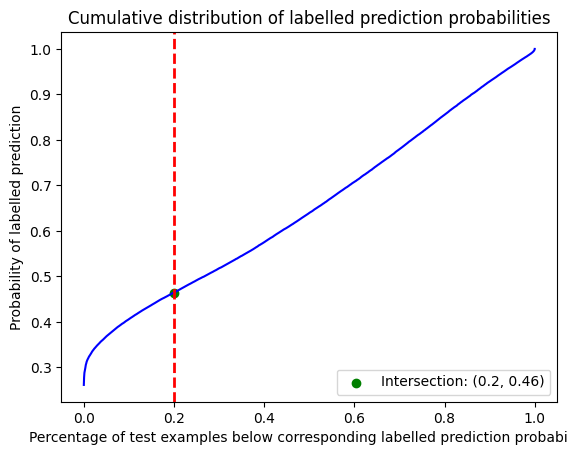

In [34]:
REJECTION_PERCENTAGE = 0.2 # percentage of examples that are rejected 

y_pred_prob = model.predict_proba(X_test_final)
y_pred_prob_max = np.sort(np.max(y_pred_prob, axis=1))
x_range = np.arange(1, len(y_pred_prob_max) + 1) / len(y_pred_prob_max)

rejection_index = int(len(y_pred_prob_max) * REJECTION_PERCENTAGE)
labelled_prediction_rejection_prob = y_pred_prob_max[rejection_index]

plt.plot(x_range, y_pred_prob_max, color='b')
plt.axvline(REJECTION_PERCENTAGE, color='r', linestyle='--', linewidth=2)
plt.scatter(REJECTION_PERCENTAGE, labelled_prediction_rejection_prob, color='green', label=f'Intersection: ({REJECTION_PERCENTAGE}, {labelled_prediction_rejection_prob:.2f})')
plt.legend()
plt.xlabel('Percentage of test examples below corresponding labelled prediction probability')
plt.ylabel('Probability of labelled prediction')
plt.title('Cumulative distribution of labelled prediction probabilities')
plt.savefig("rejection-probability-threshold-randomoversampler.png")
plt.show()

#### Rejection of classification - rejection by distance in document embedding space

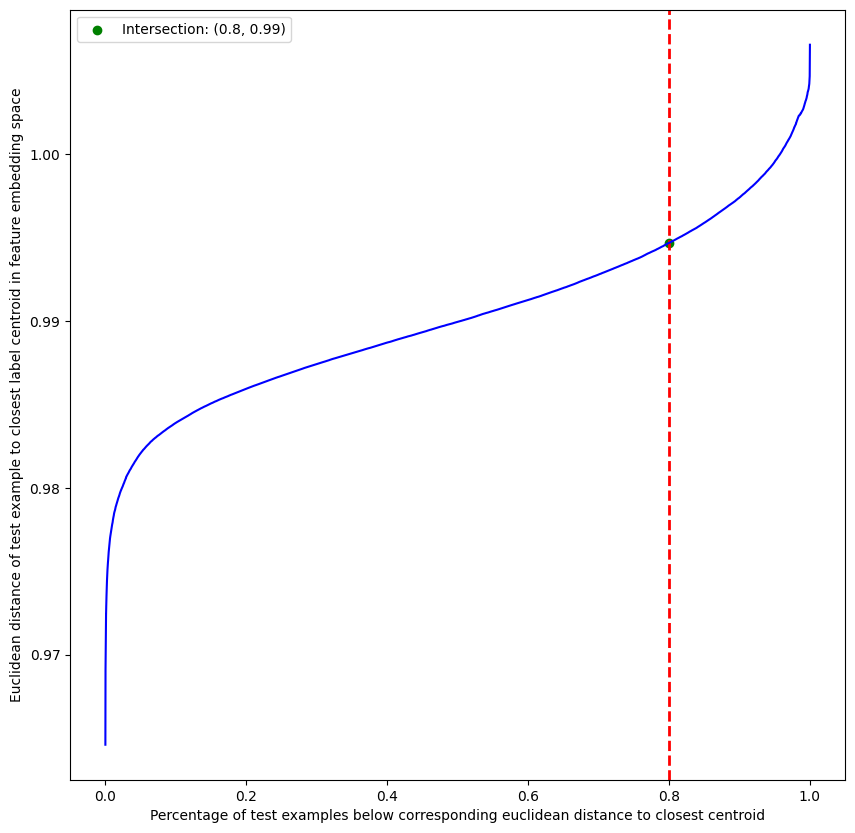

In [35]:
# 1) Filter by y_train
# 2) mean on each column for each labels "centroid"
# 3) Find distance from "centroid" to current
unique_labels = np.unique(y_train)
mean_labels = np.zeros((len(unique_labels), X_train.shape[1]))

row = 0
for label in unique_labels:
    indices = y_train.index[y_train == label]
    points = X_train[indices]
    label_mean_point = points.mean(axis=0)
    mean_labels[row] = label_mean_point
    row += 1
    
distances = pairwise_distances(X_test_final, mean_labels, metric='euclidean')
min_distances = np.min(distances, axis=1)
min_distances = min_distances.flatten()
min_distances.sort()

x_range = np.arange(1, len(min_distances) + 1) / len(min_distances)
rejection_index = int(len(min_distances) * (1 - REJECTION_PERCENTAGE))
euc_dist_rejection_boundary = min_distances[rejection_index]

plt.figure(figsize=(10, 10))
plt.axvline(1 - REJECTION_PERCENTAGE, color='r', linestyle='--', linewidth=2)
plt.scatter(1 - REJECTION_PERCENTAGE, euc_dist_rejection_boundary, color='green', label=f'Intersection: ({1 - REJECTION_PERCENTAGE}, {euc_dist_rejection_boundary:.2f})')
plt.legend()
plt.plot(x_range, min_distances, color='b')
plt.xlabel('Percentage of test examples below corresponding euclidean distance to closest centroid')
plt.ylabel('Euclidean distance of test example to closest label centroid in feature embedding space')
plt.savefig("rejection-euclidean-distance-randomoversampler.png")
plt.show()